In [4]:
import pandas as pd
import numpy as np
import jenkspy
from lifelines import KaplanMeierFitter
from scipy.special import expit
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib import rc

In [5]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

# 数据读取和处理
df = pd.read_excel("initial_data/nipt_data.xlsx", sheet_name="男胎检测数据")
df = df[df['Y染色体浓度'].notna()].copy()

def convert_ga_to_decimal(ga_str):
    """将"Xw+Y"格式转换为小数周"""
    if pd.isna(ga_str):
        return np.nan
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan

# 转换孕周并筛选10-25周样本
df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

# GC含量筛选
df['GC含量_百分比'] = df['GC含量'] * 100
df = df[(df['GC含量_百分比'] >= 40) & (df['GC含量_百分比'] <= 60)]

# Y染色体浓度筛选
df['Y染色体浓度_百分比'] = df['Y染色体浓度'] * 100
df = df[(df['Y染色体浓度_百分比'] >= 0) & (df['Y染色体浓度_百分比'] <= 15)]

# 提取核心数据
Y_data_whole = df['Y染色体浓度'].values
wk_data_whole = df['小数孕周'].values
BMI_data_whole = df['孕妇BMI'].values
event_observed = (Y_data_whole >= 0.04).astype(int)

print(f"数据样本数: {len(Y_data_whole)}")

# -----------------------
# 核心函数定义
# -----------------------

def create_labels_from_breaks(bmi_values, breaks):
    """根据边界点创建分组标签"""
    labels = np.digitize(bmi_values, bins=breaks[1:-1], right=True)
    return np.clip(labels, 0, len(breaks) - 2)

def fit_kaplan_meier(event_times, labels, event_observed):
    """拟合Kaplan-Meier生存曲线"""
    kmf_dict = {}
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = (labels == label)
        if np.sum(mask) > 5:
            kmf = KaplanMeierFitter()
            kmf.fit(event_times[mask], event_observed=event_observed[mask])
            kmf_dict[label] = kmf
    return kmf_dict

def get_survival_probability(kmf_dict, label, time_point):
    """获取生存概率 S(t) = 未达标概率"""
    if label not in kmf_dict:
        return 1.0
    S = kmf_dict[label].predict(time_point)
    return float(S) if not np.isnan(S) else 1.0

def get_failure_probability(kmf_dict, label, time_point):
    """获取失败概率 p(t) = 达标概率"""
    return 1 - get_survival_probability(kmf_dict, label, time_point)

def early_risk_weight(time, t_early=12, k=0.5):
    """过早检测风险权重函数"""
    return expit(-k * (time - t_early))

def late_risk_weight(time, t_late=20, k=0.5):
    """过晚检测风险权重函数"""
    return expit(k * (time - t_late))

def comprehensive_loss(time, label, kmf_dict, alpha=1.0, beta=1.0):
    """综合损失函数"""
    p_t = get_failure_probability(kmf_dict, label, time)
    w_early = early_risk_weight(time)
    w_late = late_risk_weight(time)
    
    early_risk = alpha * (1 - p_t) * w_early
    late_risk = beta * p_t * w_late
    
    return early_risk + late_risk, early_risk, late_risk, p_t

def optimize_group_times(kmf_dict, n_groups):
    """优化每个分组的最佳时间点"""
    optimal_times = []
    optimal_losses = []
    
    for label in range(n_groups):
        if label in kmf_dict:
            weeks = np.linspace(10, 25, 151)
            losses = [comprehensive_loss(w, label, kmf_dict)[0] for w in weeks]
            optimal_time = weeks[np.argmin(losses)]
            optimal_loss = min(losses)
            
            optimal_times.append(optimal_time)
            optimal_losses.append(optimal_loss)
        else:
            optimal_times.append(20.0)
            optimal_losses.append(0.0)
    
    return optimal_times, optimal_losses

def calculate_total_loss(breaks, bmi_values, event_times, event_observed):
    """计算给定分组下的总体损失"""
    labels = create_labels_from_breaks(bmi_values, breaks)
    group_sizes = [np.sum(labels == i) for i in range(len(breaks) - 1)]
    if any(size < 3 for size in group_sizes):
        return float('inf'), None, None, labels
    
    kmf_dict = fit_kaplan_meier(event_times, labels, event_observed)
    optimal_times, optimal_losses = optimize_group_times(kmf_dict, len(breaks) - 1)
    
    total_loss = sum(optimal_losses)
    return total_loss, optimal_times, kmf_dict, labels

def grid_search_optimization(n_groups=4, grid_points=8):
    """网格搜索优化区间分割"""
    min_bmi, max_bmi = np.min(BMI_data_whole), np.max(BMI_data_whole)
    best_loss = float('inf')
    best_breaks = None
    best_times = None
    best_kmf = None
    best_labels = None
    
    # 存储优化过程用于可视化
    optimization_history = []
    
    grid = np.linspace(min_bmi + 0.5, max_bmi - 0.5, grid_points)
    total_combinations = len(list(combinations(grid, n_groups-1)))
    
    print("正在进行网格搜索优化...")
    
    for inner_breaks in combinations(grid, n_groups-1):
        breaks = sorted([min_bmi] + list(inner_breaks) + [max_bmi])
        
        try:
            total_loss, optimal_times, kmf_dict, labels = calculate_total_loss(
                breaks, BMI_data_whole, wk_data_whole, event_observed
            )
            
            # 记录优化过程
            optimization_history.append({
                'breaks': breaks.copy(),
                'loss': total_loss,
                'times': optimal_times.copy() if optimal_times else None
            })
            
            if total_loss < best_loss:
                best_loss = total_loss
                best_breaks = breaks
                best_times = optimal_times
                best_kmf = kmf_dict
                best_labels = labels
                
        except Exception:
            continue
    
    return best_breaks, best_times, best_kmf, best_loss, best_labels, optimization_history

# -----------------------
# 执行优化
# -----------------------

print("=" * 60)
print("BMI分组与NIPT时间优化")
print("=" * 60)

n_groups = 4
grid_points = 8

best_breaks, best_times, best_kmf, best_loss, best_labels, optimization_history = grid_search_optimization(
    n_groups=n_groups, grid_points=grid_points
)

# 计算Jenks分组结果
jenks_breaks = jenkspy.jenks_breaks(BMI_data_whole, n_groups)
jenks_loss, jenks_times, jenks_kmf, jenks_labels = calculate_total_loss(
    jenks_breaks, BMI_data_whole, wk_data_whole, event_observed
)

数据样本数: 519
BMI分组与NIPT时间优化
正在进行网格搜索优化...


In [6]:
# -----------------------
# 输出最终结果
# -----------------------

print("\n" + "=" * 60)
print("优化结果（基于Jenks分组）")
print("=" * 60)
print(f"BMI分组边界: {[f'{x:.2f}' for x in breaks]}")
print(f"各组最优NIPT时间点: {[f'{x:.2f}' for x in optimal_times]}")
print(f"总体损失: {total_loss:.6f}")

for i in range(len(breaks) - 1):
    group_size = np.sum(labels == i)
    if group_size > 0 and i in kmf_dict:
        total_loss, early_risk, late_risk, p_t = comprehensive_loss(optimal_times[i], i, kmf_dict)
        
        print(f"\n第{i}组 (BMI: {breaks[i]:.2f}-{breaks[i+1]:.2f}):")
        print(f"  样本数量: {group_size}")
        print(f"  最优NIPT时间: {optimal_times[i]:.2f}周")
        print(f"  达标概率: {p_t:.3f}")
        print(f"  过早风险: {early_risk:.4f}")
        print(f"  过晚风险: {late_risk:.4f}")
        print(f"  总风险: {total_loss:.4f}")
    else:
        print(f"\n第{i}组: 无样本数据")

print(f"\n总体损失: {total_loss:.6f}")

# -----------------------
# 详细统计信息
# -----------------------

print("\n" + "=" * 60)
print("详细统计信息")
print("=" * 60)

for i in range(len(breaks) - 1):
    mask = (labels == i)
    if np.sum(mask) > 0:
        group_bmi = BMI_data_whole[mask]
        group_weeks = wk_data_whole[mask]
        group_y = Y_data_whole[mask]
        
        print(f"\n第{i}组统计 (BMI: {breaks[i]:.2f}-{breaks[i+1]:.2f}):")
        print(f"  样本数: {len(group_bmi)}")
        print(f"  BMI范围: {np.min(group_bmi):.2f}-{np.max(group_bmi):.2f}")
        print(f"  BMI均值: {np.mean(group_bmi):.2f} ± {np.std(group_bmi):.2f}")
        print(f"  孕周范围: {np.min(group_weeks):.2f}-{np.max(group_weeks):.2f}")
        print(f"  Y浓度>4%比例: {np.mean(group_y >= 0.04):.3f}")
        
        if i in kmf_dict:
            total_loss, early_risk, late_risk, p_t = comprehensive_loss(optimal_times[i], i, kmf_dict)
            print(f"  最优时间点风险: {total_loss:.4f}")


优化结果（基于Jenks分组）


NameError: name 'breaks' is not defined

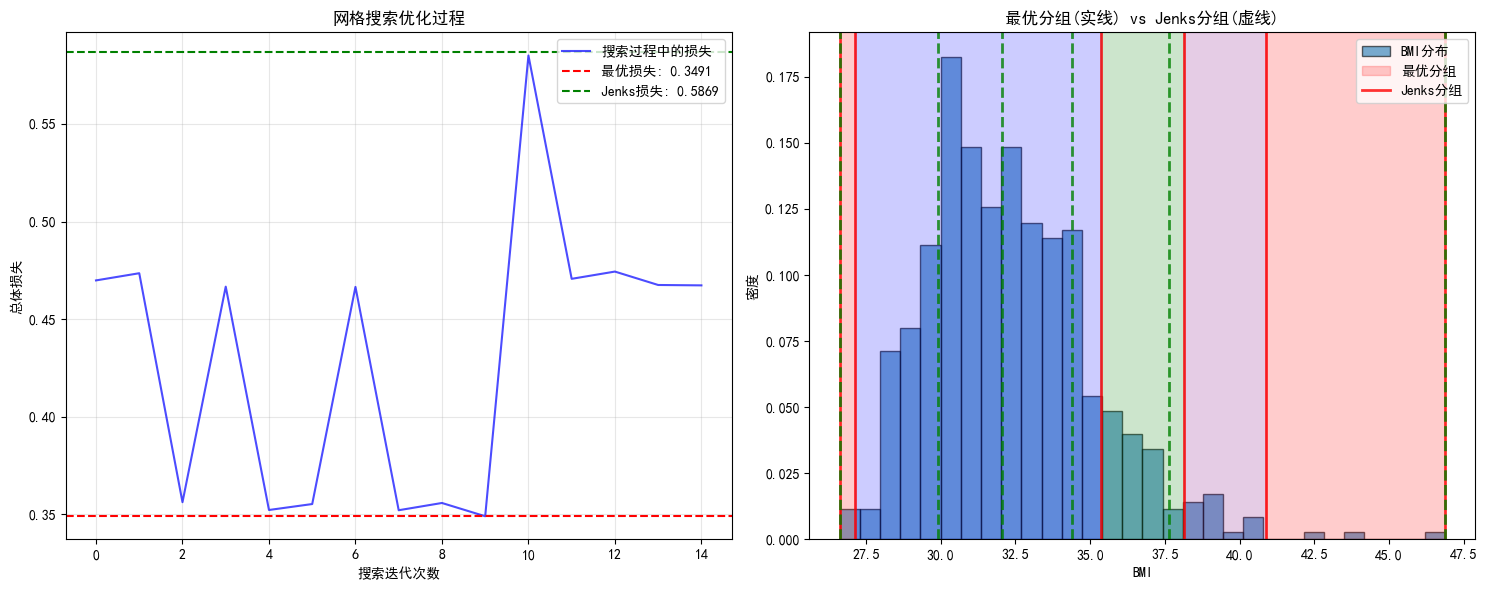

In [ ]:
# -----------------------
# 可视化
# -----------------------

# 图1: 优化过程中的损失变化
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
losses = [item['loss'] for item in optimization_history if item['loss'] < float('inf')]
iterations = range(len(losses))

plt.plot(iterations, losses, 'b-', alpha=0.7, label='搜索过程中的损失')
plt.axhline(y=best_loss, color='r', linestyle='--', label=f'最优损失: {best_loss:.4f}')
plt.axhline(y=jenks_loss, color='g', linestyle='--', label=f'Jenks损失: {jenks_loss:.4f}')

plt.xlabel('搜索迭代次数')
plt.ylabel('总体损失')
plt.title('网格搜索优化过程')
plt.legend()
plt.grid(True, alpha=0.3)

# 图2: 最优分组与Jenks分组的BMI分布对比
plt.subplot(1, 2, 2)
plt.hist(BMI_data_whole, bins=30, alpha=0.6, edgecolor='black', density=True, label='BMI分布')

# 绘制最优分组边界
colors = ['red', 'blue', 'green', 'purple']
for i, break_point in enumerate(best_breaks):
    if i < len(best_breaks) - 1:
        plt.axvspan(best_breaks[i], best_breaks[i+1], alpha=0.2, color=colors[i % len(colors)])
    plt.axvline(x=break_point, color='red', linestyle='-', linewidth=2, alpha=0.8)

# 绘制Jenks分组边界
for break_point in jenks_breaks:
    plt.axvline(x=break_point, color='green', linestyle='--', linewidth=2, alpha=0.8)

plt.xlabel('BMI')
plt.ylabel('密度')
plt.title('最优分组(实线) vs Jenks分组(虚线)')
plt.legend(['BMI分布', '最优分组', 'Jenks分组'])

plt.tight_layout()
plt.savefig('optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()